<a href="https://colab.research.google.com/github/chandra17iith/GAN_Project/blob/main/GAN_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Generation

In [ ]:
import cv2
import numpy as np
import os
import random

def generate_image(width, height, num_shapes):
    """Generates an image with randomly placed hollow circles and ellipses."""
    # Create a blank white canvas
    image = np.ones((height, width, 1), dtype=np.uint8) * 255

    for _ in range(num_shapes):
        shape_type = random.choice(["circle", "ellipse"])  # Randomly select shape type
        color = tuple(random.randint(0, 255) for _ in range(3))  # Random color (RGB)
        center = (random.randint(0, width), random.randint(0, height))  # Random position

        thickness = random.randint(2, 5)  # Random thickness for hollow effect

        if shape_type == "circle":
            radius = random.randint(10, min(width, height) // 5)
            cv2.circle(image, center, radius, color, thickness=thickness)  # Hollow circle
        else:
            axes = (random.randint(10, width // 5), random.randint(10, height // 5))
            angle = random.randint(0, 360)
            cv2.ellipse(image, center, axes, angle, 0, 360, color, thickness=thickness)  # Hollow ellipse

    return image

def generate_dataset(output_folder, num_images, width=256, height=256, num_shapes=10):
    """Generates a dataset of images and saves them in a folder."""
    os.makedirs(output_folder, exist_ok=True)  # Ensure output directory exists

    for i in range(num_images):
        img = generate_image(width, height, num_shapes)
        img_path = os.path.join(output_folder, f"image_{i+1}.png")  # Save as PNG
        cv2.imwrite(img_path, img)

    print(f"Dataset created with {num_images} images in '{output_folder}'")

# Example: Generate 100 images in 'dataset' folder
generate_dataset(output_folder="dataset", num_images=60000)


Dataset created with 60000 images in 'dataset'


# `GAN - MODEL`

## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
class CircleDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("L")  # Convert to grayscale
        if self.transform:
            return self.transform(image)
        return image

## Hyperparameter

In [ ]:
image_size = 64
latent_dim = 100
batch_size = 128
epochs = 25
learning_rate = 0.0002

## Transformation

In [ ]:
DATA_DIR='./dataset'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CircleDataset(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

## Generator

In [ ]:
Generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)

In [23]:
# Discriminator
Discriminator = nn.Sequential(
    # in: 1 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [21]:
latent_vector = torch.randn(batch_size, latent_dim, 1, 1).to(device)  # Reshape to [batch_size, latent_dim, 1, 1]
generator = Generator.to(device)
output = generator(latent_vector)

In [24]:
discriminator = Discriminator.to(device)

In [25]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [28]:
for epoch in range(epochs):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, device=device).view(batch_size, latent_dim, 1, 1)  # Reshape z
        fake_imgs = generator(z)  # Generate fake images

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    if epoch % 5 == 0:
        vutils.save_image(fake_imgs, f"generated_{epoch}.png", normalize=True)

print("Training complete!")


Epoch [1/25] | D Loss: 0.0288 | G Loss: 6.0757
Epoch [2/25] | D Loss: 0.0998 | G Loss: 4.1631
Epoch [3/25] | D Loss: 0.0338 | G Loss: 5.9367
Epoch [4/25] | D Loss: 0.0151 | G Loss: 5.6795
Epoch [5/25] | D Loss: 0.0076 | G Loss: 6.7845
Epoch [6/25] | D Loss: 0.0385 | G Loss: 6.6690
Epoch [7/25] | D Loss: 0.0238 | G Loss: 6.2828
Epoch [8/25] | D Loss: 0.0175 | G Loss: 6.8390
Epoch [9/25] | D Loss: 0.0083 | G Loss: 6.1478
Epoch [10/25] | D Loss: 0.0068 | G Loss: 6.1762
Epoch [11/25] | D Loss: 0.0073 | G Loss: 6.1716
Epoch [12/25] | D Loss: 0.0542 | G Loss: 5.7324
Epoch [13/25] | D Loss: 0.0188 | G Loss: 5.8681
Epoch [14/25] | D Loss: 0.0372 | G Loss: 5.6394
Epoch [15/25] | D Loss: 0.0098 | G Loss: 6.4808
Epoch [16/25] | D Loss: 0.0026 | G Loss: 7.5574
Epoch [17/25] | D Loss: 0.0077 | G Loss: 5.9472
Epoch [18/25] | D Loss: 0.0279 | G Loss: 13.7991
Epoch [19/25] | D Loss: 0.0307 | G Loss: 9.2150
Epoch [20/25] | D Loss: 0.0064 | G Loss: 6.8848
Epoch [21/25] | D Loss: 0.0010 | G Loss: 7.6223


In [29]:
from IPython.display import Image

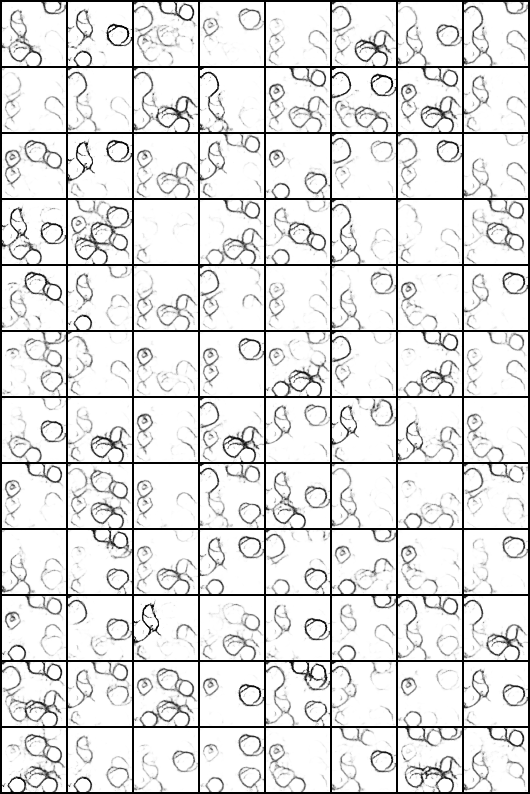

In [30]:
Image('./generated_15.png')

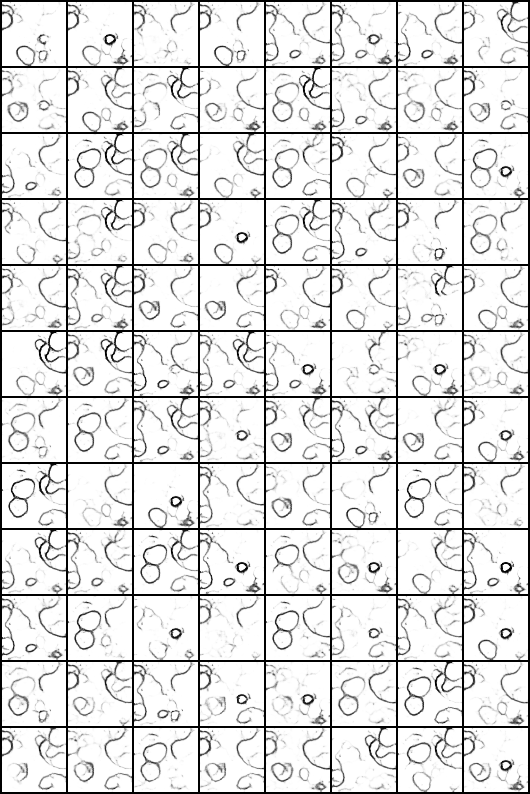

In [31]:
Image('./generated_20.png')

In [37]:

num_images = 10
latent_dim = 100

z = torch.randn(num_images, latent_dim, 1, 1).to(device)  # Shape: [num_images, latent_dim, 1, 1]

with torch.no_grad():
    generated_imgs = generator(z)

# Save the images
vutils.save_image(generated_imgs, "generated_images.png", nrow=num_images, normalize=True)

print(f"{num_images} images generated and saved!")


10 images generated and saved!


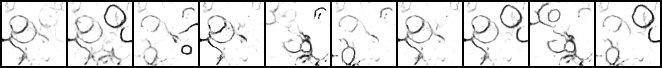

In [38]:
Image('./generated_images.png')